## Setup

In [1]:
shap.initjs()

from sklearn.pipeline import Pipeline
from BMEMasterThesis.services.PicaiDataService import PicaiDataService
from BMEMasterThesis.visualizer import PicaiVisualizer
from BMEMasterThesis.utils import Datasets, PATHS
from BMEMasterThesis.algorithm import decodeMethod, decodeModel

from sklearn.discriminant_analysis import StandardScaler

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
import json


dataset = Datasets.ORIGINAL

dataService = PicaiDataService()
radiomicsFile = PATHS.getRadiomicFile(dataset)
radiomicFeatures = pd.read_csv(radiomicsFile)
shapValuePlotDir = PATHS.getShapValuePlotDir(dataset)

picaiMetadata = dataService.getMetadata()    
        
jointDfs = pd.merge(picaiMetadata, radiomicFeatures, on='Patient_Id')
conditions = [
    (jointDfs['Label'] == 2) & (jointDfs['Manufacturer'] == 'Philips Medical Systems'),
    (jointDfs['Label'] == 2) & (jointDfs['Manufacturer'] == 'SIEMENS'),
    (jointDfs['Label'] > 2)  & (jointDfs['Manufacturer'] == 'Philips Medical Systems'),
    (jointDfs['Label'] > 2)  & (jointDfs['Manufacturer'] == 'SIEMENS'),
]

jointDfs['StratifiedLabels'] = np.select(conditions, [0, 1, 2, 3])
yStrat = jointDfs['StratifiedLabels'].to_numpy()

# Get features and original labels
patientIds = radiomicFeatures.pop('Patient_Id').to_list()
labels = radiomicFeatures.pop('Label')
radiomicFeaturesNames = radiomicFeatures.columns.to_list()

X = radiomicFeatures.to_numpy()
y = np.copy(labels)
y[y == 2] = 0   # 0: ISUP = 2,
y[y > 2] = 1    # 1: ISUP > 2

indicesData = json.load(PATHS.PICAI_INDICES_FILE.open())
train_index = np.asarray(indicesData['train_idx'])
test_index = np.asarray(indicesData['test_idx'])

Xtrain, Xtest = X[train_index], X[test_index]
ytrain, ytest = y[train_index], y[test_index]

print(Xtrain.shape, Xtest.shape)
print(ytrain.shape, ytest.shape)

bestMethod, bestModel = PicaiVisualizer(dataService=dataService).visualizeDataset(dataset)
bestMethodResultFile = PATHS.getResultsForCombinationDir(dataset, bestMethod, bestModel)
bestMethodParams = json.load(bestMethodResultFile.open())['best_method_params']


(146, 1132) (79, 1132)
(146,) (79,)


## Fit pipeline

In [57]:
method = decodeMethod(bestMethod)
method.set_params(**bestMethodParams)
model = decodeModel(bestModel)

pipeline = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('feature_selector', method),
    ('classifier', model)
])

pipeline.fit(Xtrain, ytrain)

Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('feature_selector',
                 UnivariateFsAlgorithm(method='spearman',
                                       selectedFeatures=[0, 1, 10, 24, 28, 38,
                                                         44, 94, 124, 130, 136,
                                                         165, 168, 251, 252,
                                                         254, 337, 338, 340,
                                                         358, 363, 368, 372,
                                                         388, 414, 423, 424,
                                                         426, 432, 449, ...],
                                       threshold=0.7)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=5))])

## Create the Explainer

In [129]:
masker = shap.maskers.Independent(data = Xtrain[:10, :])
explainer = shap.PermutationExplainer(pipeline.predict_proba, masker, max_evals=2265)

explanation = explainer(Xtest)
# shap_values = explainer.shap_values(Xtest)
# print(explanation)
shap_values = explanation.values
base_values = explanation.base_values 

print(shap_values.shape)

PermutationExplainer explainer: 80it [00:54,  1.19it/s]                        

(79, 1132, 2)


## Generate Plots

(2, 79, 1132)
(2, 79)


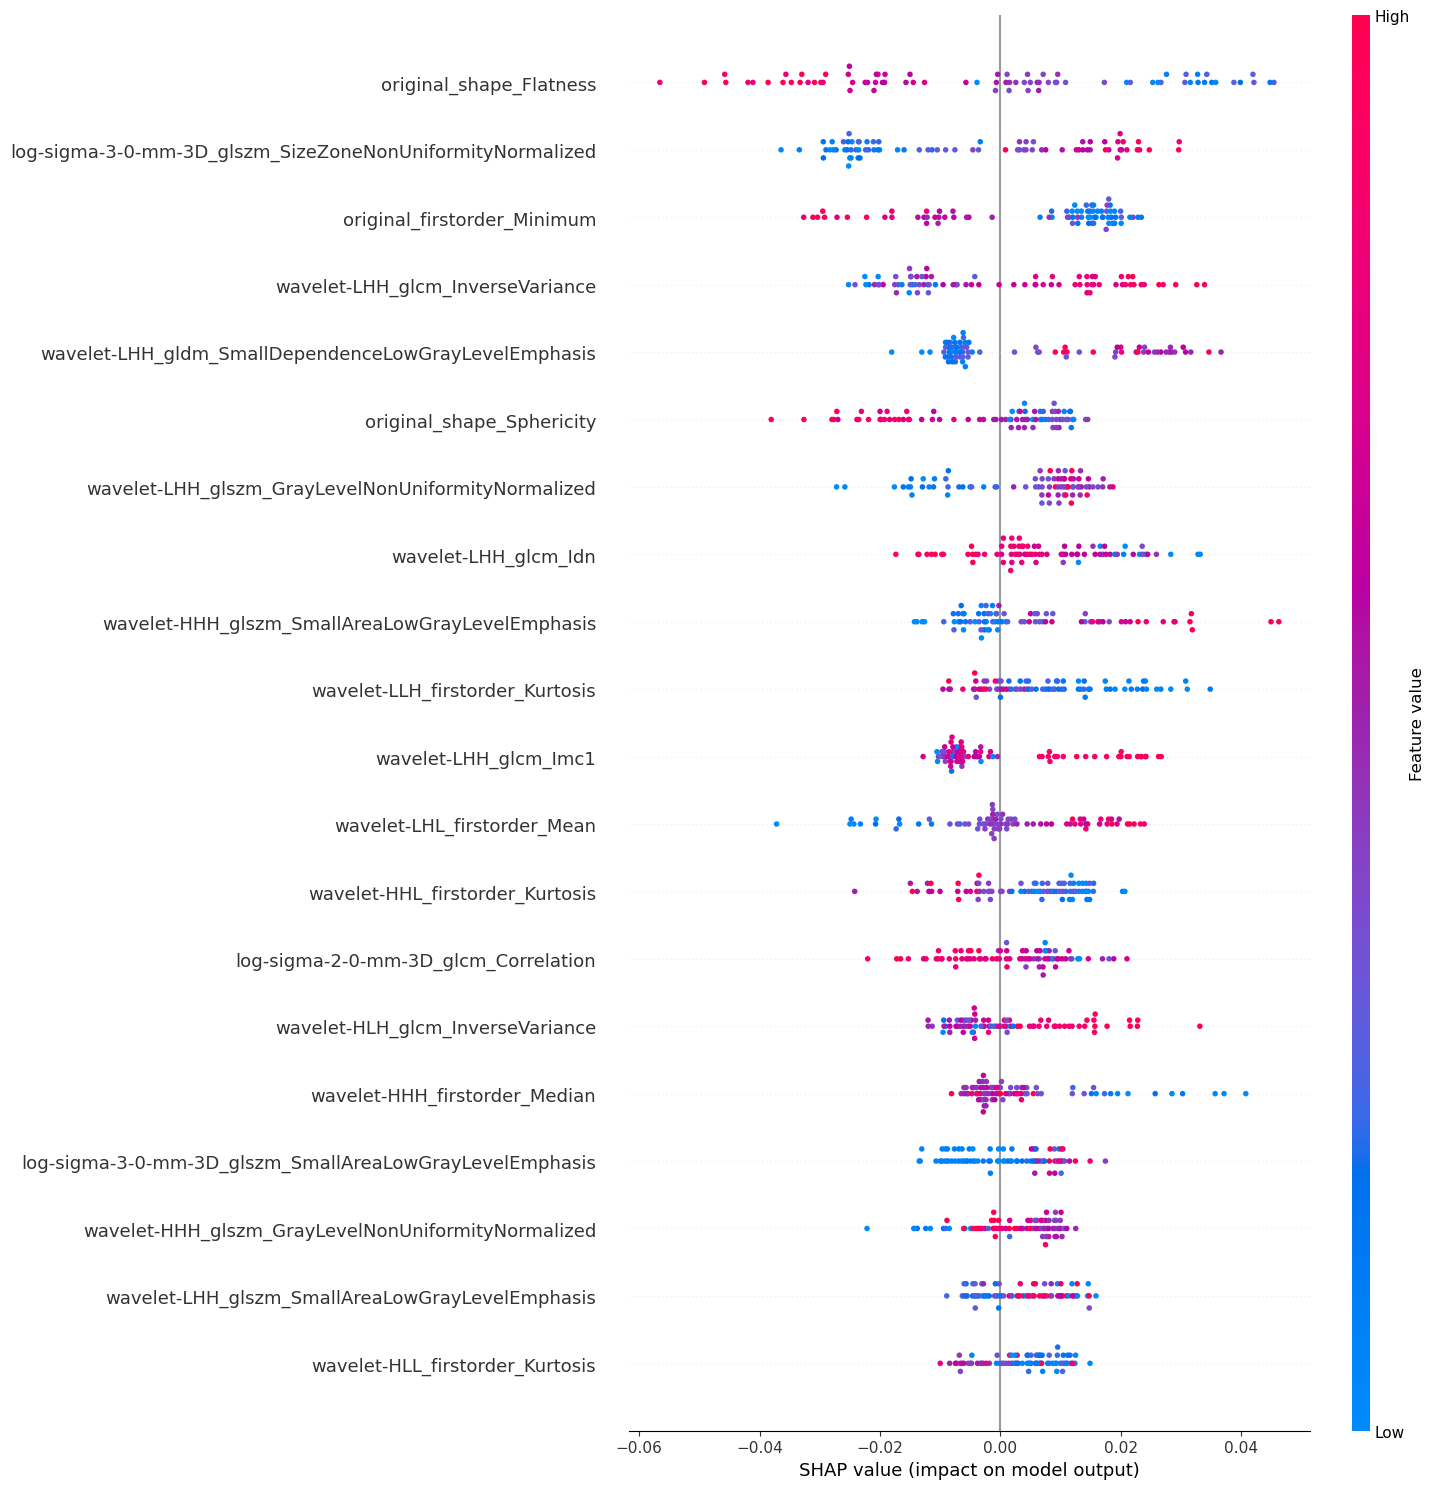

In [180]:
shap_values = np.moveaxis(explanation.values, [0, 1, 2], [1, 2, 0])
print(shap_values.shape)

base_values = np.moveaxis(explanation.base_values, [0, 1], [1, 0])
print(base_values.shape)

shap.summary_plot(shap_values[0], Xtest, feature_names=radiomicFeaturesNames, show=False, plot_size=(15, 15))
plt.savefig(shapValuePlotDir.joinpath('.summary_plot.png'), format='png')
plt.show()
plt.close()

